In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
#dataset
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.92MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


In [ ]:
latent_dim = 20  # 潛在空間維度

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)  #20*20 壓縮
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Average loss: {avg_loss:.4f}")

Epoch 1, Average loss: 108.8927
Epoch 2, Average loss: 108.0951
Epoch 3, Average loss: 107.4022
Epoch 4, Average loss: 106.9395
Epoch 5, Average loss: 106.5018
Epoch 6, Average loss: 106.1255
Epoch 7, Average loss: 105.8523
Epoch 8, Average loss: 105.5433
Epoch 9, Average loss: 105.3222
Epoch 10, Average loss: 105.0947
Epoch 11, Average loss: 104.9407
Epoch 12, Average loss: 104.7304
Epoch 13, Average loss: 104.5275
Epoch 14, Average loss: 104.4143
Epoch 15, Average loss: 104.2422
Epoch 16, Average loss: 104.1050
Epoch 17, Average loss: 103.9766
Epoch 18, Average loss: 103.8794
Epoch 19, Average loss: 103.7318
Epoch 20, Average loss: 103.6406
Epoch 21, Average loss: 103.5352
Epoch 22, Average loss: 103.4398
Epoch 23, Average loss: 103.3281
Epoch 24, Average loss: 103.2738
Epoch 25, Average loss: 103.1560
Epoch 26, Average loss: 103.1155
Epoch 27, Average loss: 103.0163
Epoch 28, Average loss: 102.9785
Epoch 29, Average loss: 102.8528
Epoch 30, Average loss: 102.8417


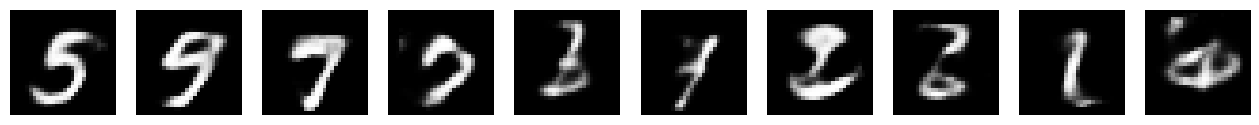

In [ ]:
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)   # 從標準常態分布取樣潛在向量
    generated = model.decode(z)                 # 用解碼器直接生成圖片

    plt.figure(figsize=(16, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()


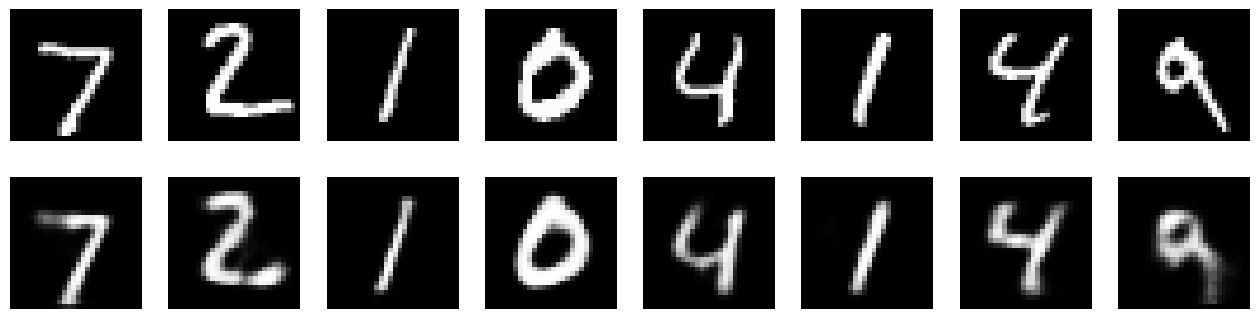

In [ ]:
model.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.to(device)
    recon_batch, _, _ = model(test_batch)

    n = 8
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # 原圖
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_batch[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")

        # 重建圖
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_batch[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")

    plt.savefig("vae_mnist_reconstruction.png")
    plt.show()